**Problem Description**

This project aims to uncover communities of chess players based on frequent game pairings (Player A vs. Player B). By analyzing these communities, we can identify underserved chess regions, detect anomalies in the Elo rating system, and classify top players based on their matchups with other elite competitors.

The dataset consists of US Chess Federation (USCF) member and game data from 2017 to 2023. Using graph theory and the Louvain clustering method, we will model players as nodes and their matchups as edges. Players with at least 10 recorded games will be grouped into communities based on shared opponents.

Once clusters are formed, we will analyze their characteristics, including geographic distribution, average ratings, and tournament availability, to gain insights into the chess ecosystem.

**Data Collection**

All data was scraped from the USCF website via a Python script. Significant cleaning was done during the scraping/warehousing phase but is outside the scope of this project. Further transformations will be discussed later in the notebook.

In [19]:
from sqlalchemy import create_engine
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import community as community_louvain


In [20]:
#Creates a SQLAlchemy engine for connecting to local PostgreSQL db
def get_sqlalchemy_engine(user, password, host, port, database):
    url = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(url)
    return engine

#Placeholder values. Peers will not have access to this DB or data. 
user = 'postgres'
password = 'password'
host = 'localhost'
port = '5433'
database = 'uscf_db'

engine = get_sqlalchemy_engine(user, password, host, port, database)


In [21]:
#Function to execute SQL query and return a df of matchups, and weight that shows the frequency of that matchup
def fetch_data_from_db(engine, query):
    try:
        df = pd.read_sql_query(query, engine)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

#Filtering out members with less than 10 pairings, as they are not regular members of a community
#Also it runs slow otherwise
query = """
    SELECT member_id, opp_member_id, COUNT(*) AS weight_column
    FROM game_results
    WHERE opp_member_id IS NOT NULL
      AND member_id IN (
          SELECT member_id
          FROM game_results
          GROUP BY member_id
          HAVING COUNT(*) >= 10
      )
    GROUP BY member_id, opp_member_id;
"""

df = fetch_data_from_db(engine, query)

df.head()


,member_id,opp_member_id,weight_column
0,10000831,10104823,1
1,10000831,12526582,1
2,10000831,12554956,1
3,10000831,13944176,3
4,10000831,14666530,1


In [32]:
# Function to build the weighted graph from the data
def build_weighted_graph_from_df(df):
    G = nx.Graph()

    for index, row in df.iterrows():
        G.add_edge(row['member_id'], row['opp_member_id'], weight=row['weight_column'])
    
    return G

G = build_weighted_graph_from_df(df)

print(f"Number of nodes: {G.number_of_nodes()}") #nodes = members
print(f"Number of edges: {G.number_of_edges()}") #edges = unique matchups (unique combinations of players)


Number of nodes: 261189
Number of edges: 3896216


**Hierarchical Louvain Clustering Model**

Finally clustering time! Two clustering methods were attempted for this project. The first was clique percolation, and the second was a hierarchical louvain method. Clique percolation was attempted because it allowed members to be a part of two clusters, which mirrors real-life where a person could be a part of two chess clubs, or be a part of one community, move, and become part of a new chess community. Unfortunately CPM was far too computationally expensive. 

Enter the Louvain model. I highly encourage any grader not familiar with louvain clustering to check out a brief overview of the method. It's an intuitive and computationally cheap method, which is important given the amount of data we're dealing with. this implementation is hierarchical which allows a level of granularity that would otherwise be unfeasible given the larger number of nodes/edges. 

In [28]:
def hierarchical_louvain(graph, resolution=1.5, min_size=50):
    #First, run Louvain on the full graph
    partition = community_louvain.best_partition(graph, resolution=resolution)
    
    #Identify communities and their members
    communities = {}
    for node, community_id in partition.items():
        communities.setdefault(community_id, []).append(node)
    
    refined_partition = {}
    
    #Refine each community if it's large enough
    for community_id, members in communities.items():
        if len(members) >= min_size:  # Only split larger communities
            #Create a subgraph for the community
            subgraph = graph.subgraph(members)
            #Run Louvain on the subgraph with a higher resolution
            sub_partition = community_louvain.best_partition(subgraph, resolution=resolution * 2)
            #Relabel sub-community IDs
            for node, sub_community_id in sub_partition.items():
                refined_partition[node] = f"{community_id}.{sub_community_id}"  #e.g., community 1 becomes 1.0, 1.1, etc.
        else:
            #Small communities stay the same
            for node in members:
                refined_partition[node] = community_id
    
    return refined_partition

261189


In [33]:
#Export results to local db. Change resolution here for parameter tuning
def export_results_to_db(engine, partition, table_name="community_detection_results_2"):
    try:
        results_df = pd.DataFrame(list(partition.items()), columns=['member_id', 'community_id'])
        
        results_df.to_sql(table_name, engine, if_exists='replace', index=False)
        
        print(f"Results have been successfully exported to the {table_name} table.")
    
    except Exception as e:
        print(f"Error exporting results to the database: {e}")

refined_partition = hierarchical_louvain(G, resolution=1.0)
export_results_to_db(engine, refined_partition)


261189
Results have been successfully exported to the community_detection_results_2 table.


In [82]:
#Some queries that will populate dataframes used to analyze and visualize the results of the clustering
community_query = """
    WITH members_cte AS (
    SELECT DISTINCT comm.member_id
    FROM community_detection_results_2 comm
    JOIN game_results results
    ON results.member_id = comm.member_id
    WHERE result IN ('W', 'L', 'D'))

    SELECT uscffide.mem_name, comm.community_id
    FROM members_cte
    JOIN uscffide
    ON uscffide.mem_id = members_cte.member_id
    JOIN community_detection_results_2 comm
    ON comm.member_id = uscffide.mem_id
"""
community_stats_query = """

    SELECT ROUND(AVG(uscffide.r_lpb_rat)) AS avg_rating, 
    COUNT(comm.member_id) AS num_members,
    comm.community_id
    FROM uscffide
    JOIN community_detection_results_2 comm
    ON comm.member_id = uscffide.mem_id
    GROUP BY comm.community_id
    HAVING AVG(uscffide.r_lpb_rat) IS NOT NULL
    ORDER BY AVG(uscffide.r_lpb_rat) DESC
"""

# Query to get the edges (game results with W, L, D)
edges_query = """
    SELECT uscffide.mem_name AS source_mem, 
    opp.mem_name AS target_mem, 
    comm.community_id AS comm_id,
    opp_comm.community_id AS opp_comm_id,
    COUNT(*) AS edge_weight
    FROM game_results results
    JOIN community_detection_results_2 comm
    ON comm.member_id = results.member_id
    JOIN uscffide
    ON uscffide.mem_id = results.member_id
    JOIN uscffide opp
    ON opp.mem_id = results.opp_member_id
    JOIN community_detection_results_2 opp_comm
    ON opp_comm.member_id = results.opp_member_id
    WHERE result IN ('W', 'L', 'D')
    GROUP BY source_mem, target_mem, comm_id, opp_comm_id
"""

# Execute the queries and load them into pandas DataFrames
community_data = pd.read_sql(community_query, engine)
community_stats_data = pd.read_sql(community_stats_query, engine)
edges_data = pd.read_sql(edges_query, engine)

# Display the first few rows of both DataFrames to verify the data
print("Community Data (First 5 rows):")
print(community_data.head())

print("\nEdges Data (First 5 rows):")
print(edges_data.head())

print("\nEdges Data (First 5 rows):")
print(community_stats_data.head())


Community Data (First 5 rows):
             mem_name community_id
0   SHORE,ROBERT DEAN          3.2
1    ANTOLINE,JAMES A        17.12
2     KOTSKI,EDWARD J         4.14
3  TIMBERLAKE,DAVID E         3.13
4      SMITH,THOMAS V         0.18

Edges Data (First 5 rows):
  source_mem             target_mem comm_id opp_comm_id  edge_weight
0   , ASHTON     FORRESTER,JONATHAN    21.3        21.3            1
1   , ASHTON          GIBSON,KELVIN    21.3        21.3            1
2   , ASHTON  KREMENTZ,ALEXIS RILEY    21.3        21.3            1
3   , ASHTON       LAMBERT,CATELYNE    21.3        21.3            1
4   , ASHTON       SISK,CHRISTOPHER    21.3        21.3            1

Edges Data (First 5 rows):
   avg_rating  num_members community_id
0      2821.0           25         4.17
1      2298.0         1240          4.1
2      2008.0          116        40.17
3      1970.0           11         4.20
4      1946.0          739        12.19


In [99]:
print('Number of unique communities(clusters):' , len(community_data.community_id.unique()))

Number of unique communities(clusters): 642


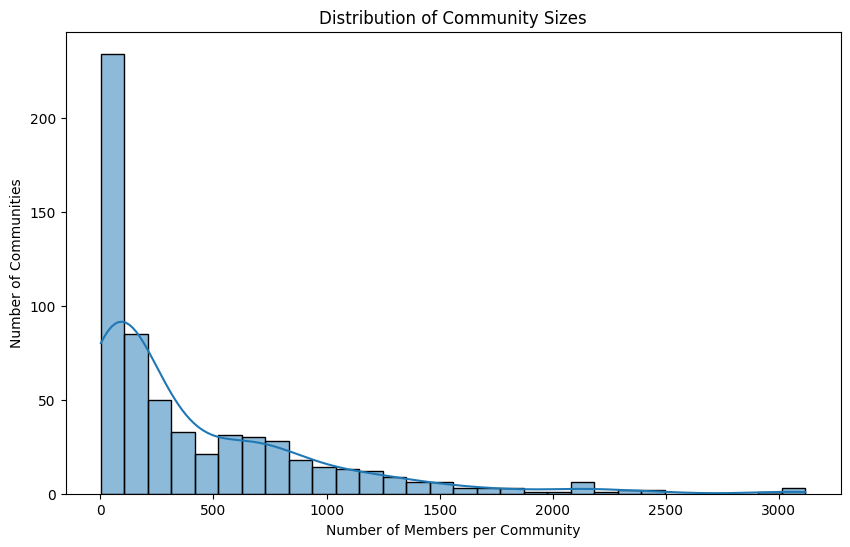

In [102]:
#Histogram of communitiy size. We want to see mostly communities of less than 100 people. 
#That tells us the model is granular enough
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(community_stats_data['num_members'], bins=30, kde=True)

# Labels and title
plt.xlabel("Number of Members per Community")
plt.ylabel("Number of Communities")
plt.title("Distribution of Community Sizes")

plt.show()

**Cluster Visualization**

Let's take a look at just one of the communities/clusters detected by the algorithm. In order to assess the model performance, I needed to rely on domain knowledge instead of labels, MSE, etc. There are no 'correct' answers when determining which community a chess player is a part of. However, we can use some intution and see what makes sense. For example, I expect the worlds top players to be in a community with eachother, and not local players/lower rated layers. To see if this is true I find the community with the highest average rating. For this particular instance of the model that is community 4.17 (remember, clustering is unordered and unlabeled). The chart below shows the members of that cluster as nodes, with the edges being games played against that particular opponent. The darker the edge, the more games played. 

As expected, this cluster is a who's who of the chess world, with a slight lean towards US players and older players as these are only games played within the US 2017-2023. We can repeat this process (and I have) with local clubs that I am more familiar with to see if the clustering matches my concept of these communities in real life. I won't show those particular cluster, but after some parameter tuning I am happy with the results. 

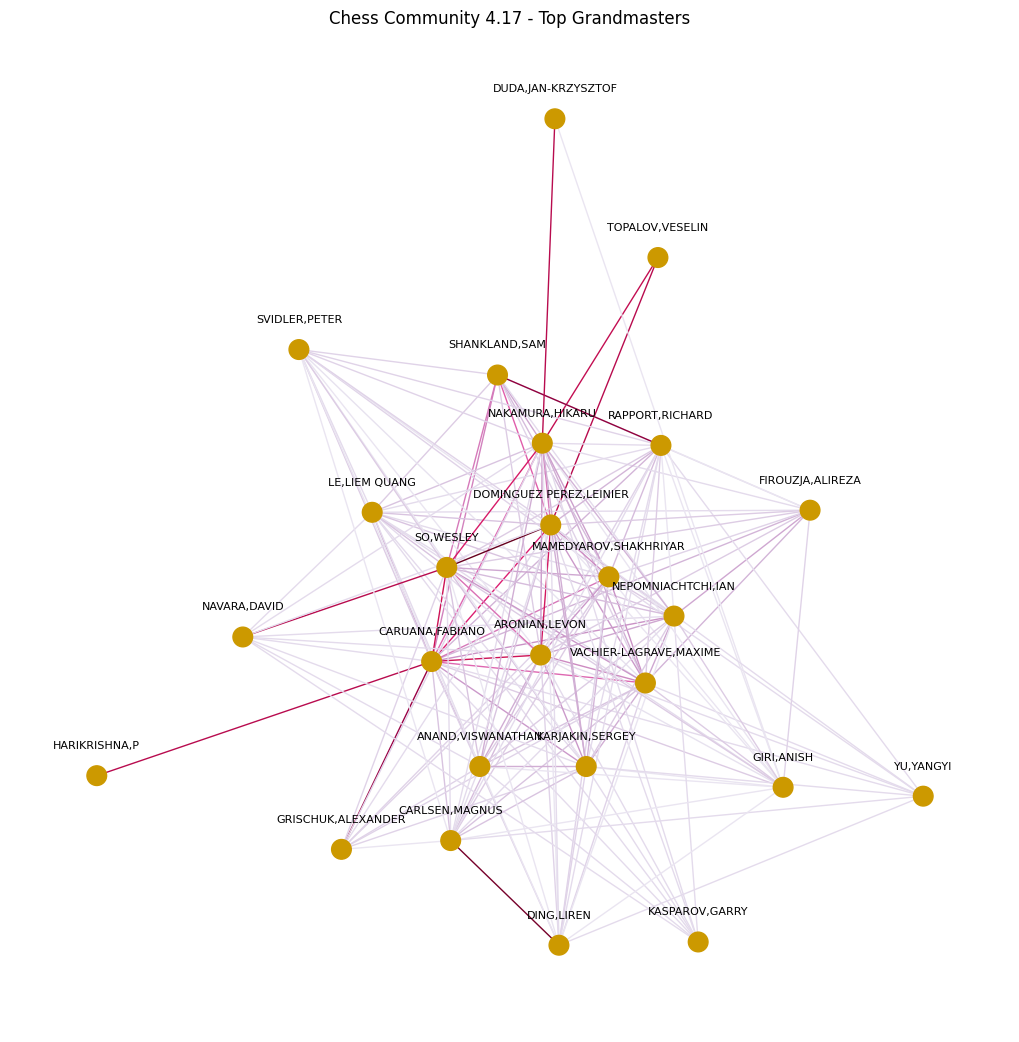

In [100]:
#Initialize a graph
G = nx.Graph()

#Limit down to just the top rated cluster. Identified by the stats query
filtered_community = community_data[community_data['community_id'] == '4.17']
filtered_edges = edges_data[edges_data['comm_id'] == '4.17']
filtered_edges = filtered_edges[filtered_edges['opp_comm_id'] == '4.17']
G.add_nodes_from(filtered_community['mem_name'].tolist())


for _, row in filtered_edges.iterrows():
    G.add_edge(row['source_mem'], row['target_mem'], weight=row['edge_weight'])


plt.figure(figsize=(10, 10))  # Increase figure size for better visibility
pos = nx.spring_layout(G, k=0.5)  # Increase k to space out nodes more

#Get edge weights and normalize them for color mapping
edges = G.edges(data=True)
weights = np.array([edge[2]['weight'] for edge in edges])  # Extract edge weights
max_weight = max(weights) if weights.size > 0 else 1
min_weight = min(weights) if weights.size > 0 else 0
normalized_weights = (weights - min_weight) / (max_weight - min_weight) + 0.1
edge_colors = [cm.PuRd(w) for w in normalized_weights]  # Change to any desired colormap
node_colors = [[0.8, 0.6, 0] for _ in G.nodes()] 


show_labels = True  


nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=200,  # Reduce node size
        edge_color=edge_colors, width=1)  # Thinner edges with color scale

if show_labels:
    for node, (x, y) in pos.items():
        plt.text(x, y + 0.05, node, fontsize=8, ha='center', va='bottom')  # Adjust the y-offset as needed

plt.title('Chess Community 4.17 - Top Grandmasters')
plt.show()


**Clique Percolation Model (Not used)**

This model was the first attempt but was discarded due too computation cost and lack of granularity. 

In [ ]:
import itertools

def find_4_cliques_optimized(G):
    """
    Find all 4-cliques in the graph by checking combinations of 4 neighbors for full connectivity.
    Optimizations:
    - Early termination when a non-clique is detected.
    - Use sets for fast neighbor lookup.
    """
    clique_list = []

    # Iterate through all nodes in the graph
    for NI in G.Nodes():
        member_id = NI.GetId()

        # Get neighbors as a set for O(1) edge checking
        neighbors = set(NI.GetOutEdges())

        # Only consider combinations of 2 neighbors since we include the current node to form 3-cliques
        if len(neighbors) >= 3:
            # Find all possible combinations of 3 neighbors
            for comb in itertools.combinations(neighbors, 3):
                candidate_clique = [member_id] + list(comb)
                
                # Early termination: Check if this is a clique
                if is_clique_optimized(G, candidate_clique):
                    clique = sorted(candidate_clique)
                    clique_list.append(clique)

    return clique_list

def is_clique_optimized(G, node_list):
    """
    Check if all nodes in the list form a clique. Uses early termination to improve efficiency.
    """
    for i in range(len(node_list)):
        for j in range(i + 1, len(node_list)):
            if not G.IsEdge(node_list[i], node_list[j]):
                return False
    return True

# Assuming the filtered data is loaded into Snap graph `G`

# Find 5-cliques in the graph
cliques_4_optimized = find_4_cliques_optimized(G)

# Output the number of 4-cliques found and a sample of the cliques
print(f"Number of 4-cliques found: {len(cliques_4_optimized)}")
cliques_4_optimized[:5]  # Show the first 5 cliques

from collections import defaultdict

def find_communities(cliques, k):
    """
    Find communities using Clique Percolation Method (CPM).
    Cliques are merged into communities if they share at least k-1 members.
    """
    # Graph to store which cliques overlap
    clique_graph = defaultdict(set)
    
    # Compare each pair of cliques
    for i, clique_a in enumerate(cliques):
        for j, clique_b in enumerate(cliques[i + 1:], i + 1):
            # Check if they share at least k-1 members
            if len(set(clique_a).intersection(set(clique_b))) >= k - 1:
                clique_graph[i].add(j)
                clique_graph[j].add(i)
    
    # Function to find all connected components (communities)
    def dfs(community, clique_index, visited):
        visited.add(clique_index)
        community.append(cliques[clique_index])
        for neighbor in clique_graph[clique_index]:
            if neighbor not in visited:
                dfs(community, neighbor, visited)

    # Find communities
    visited = set()
    communities = []
    
    for i in range(len(cliques)):
        if i not in visited:
            community = []
            dfs(community, i, visited)
            communities.append(community)

    return communities

# Find communities
communities = find_communities(cliques_4_optimized, k=4)

# Output number of communities found and a sample
print(f"Number of communities found: {len(communities)}")
for i, community in enumerate(communities[:5]):
    print(f"Community {i + 1}: {community}")